In [79]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import torch

plt.close('all')

plt.rc('font', size=14)          # controls default text sizes
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [80]:
## Parameters
exp_sys = 'Highdim' # experiment system BrownianBridge, NoisyOscillator, NyquistJohnson, Highdim
init_dist = 'Gaussian' # initial distribution Gaussian, Circle
target_dist = '4G' # 2G, 4G, Circle
N = 2000
tf = 1
T = 1000

In [81]:
## Load data
X_f = np.load('exp_result_data/X_f_{}_{}_to_{}.npy'.format(exp_sys, init_dist, target_dist))
X_p = np.load('exp_result_data/X_p_{}_{}_to_{}.npy'.format(exp_sys, init_dist, target_dist))
x_0 = np.load('exp_result_data/x_0_{}_{}_to_{}.npy'.format(exp_sys, init_dist, target_dist))
y = np.load('exp_result_data/y_{}_{}_to_{}.npy'.format(exp_sys, init_dist, target_dist))

t_N = torch.linspace(0.0, tf, T).repeat(N,1).reshape(N,T,1).permute(1,0,2) # shape (T,N,1)

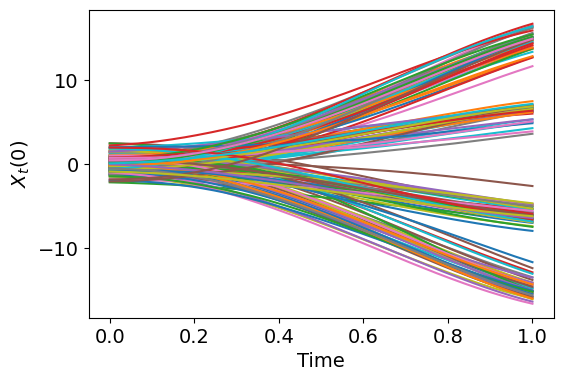

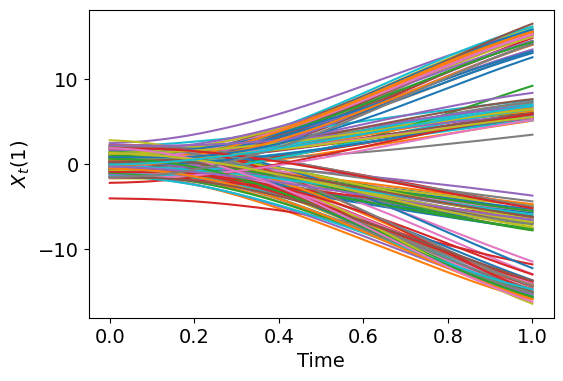

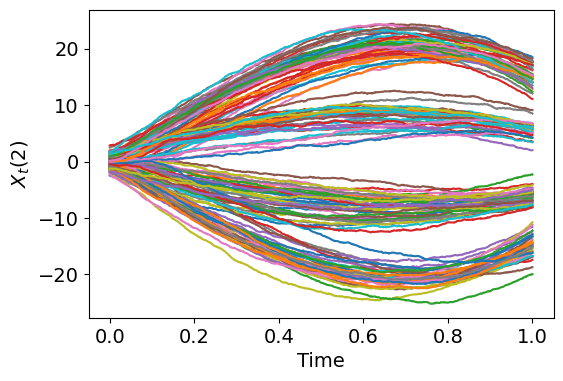

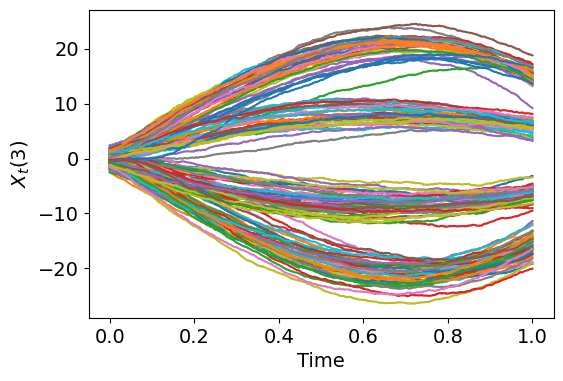

In [82]:
idx = torch.randperm(N)[:150]

## X trajectory respect to time
for i in range(X_p.shape[2]):
    plt.figure(figsize=(6,4))
    plt.plot(t_N[:,0,0], X_p[:,idx,i])
    plt.xlabel('Time')
    plt.ylabel(fr'$X_t({i})$')
plt.show()


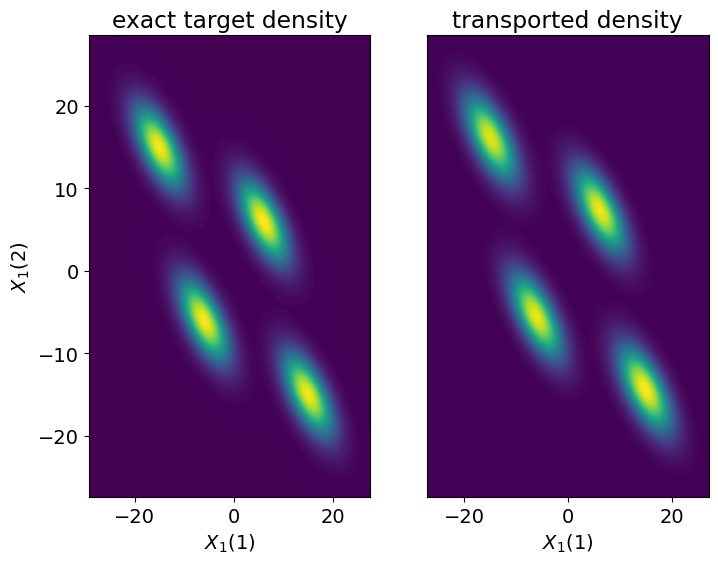

In [83]:
## Heatmap 
plt.figure(figsize=(8, 6))

# Plot the 2D heat density map for X_f
plt.subplot(1, 2, 1)
sns.kdeplot(
    x=X_f[-1, :, 0],
    y=X_f[-1, :, 1],
    # cmap="Reds",
    cmap="viridis",
    # cmap="mako",
    fill=True,
    cbar=True*0,
    levels=100,
    thresh=-0.01,
)
plt.title("exact target density")
plt.xlabel(r"$X_1(1)$")
plt.ylabel(r"$X_1(2)$")
# plt.xlim(-23,23)
# plt.ylim(-23,23)

# Plot the 2D heat density map for X_b
plt.subplot(1, 2, 2)
sns.kdeplot(
    x=X_p[-1, :, 0],
    y=X_p[-1, :, 1],
    # cmap="Greens",
    cmap="viridis",
    # cmap="mako",
    fill=True,
    cbar=True*0,
    levels=100,
    thresh=0,
)
plt.title("transported density")
plt.xlabel(r"$X_1(1)$")
# plt.xlim(-23,23)
# plt.ylim(-23,23)
plt.yticks([])
plt.show()

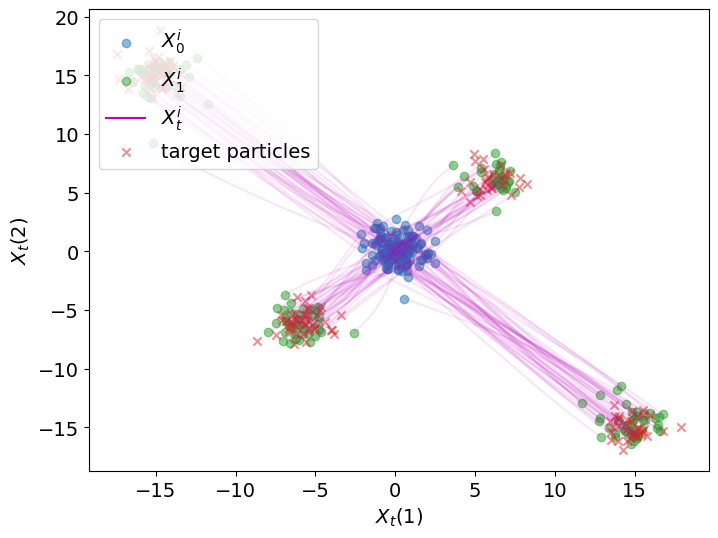

In [85]:
## Plot X trajectory and compare with target density

plt.figure(figsize=(8,6 ))
for i in idx: 
    plt.plot(X_p[:,i,0], X_p[:,i,1], color='m', alpha=0.1)

plt.scatter(X_p[0,idx,0], X_p[0,idx,1], color='C0', label= r'$X_0^i$', alpha=0.5)
plt.scatter(X_p[-1,idx,0], X_p[-1,idx,1], color='C2', label= r'$X_1^i$', alpha=0.5)
plt.plot([],[],color='m',label=r'$X_t^i$')


plt.scatter(y[idx,0], y[idx,1], color='C3', label= 'target particles', alpha=0.5, marker='x')

# plt.xlim(-13,13)
# plt.ylim(-13,13)

plt.legend(loc=2) # 2 G
plt.xlabel(r'$X_t(1)$')
plt.ylabel(r'$X_t(2)$')
plt.show()

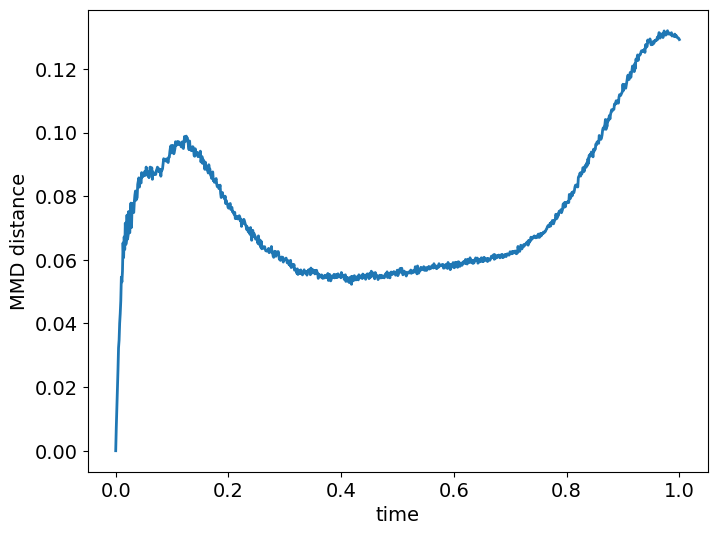

In [86]:
## Generate MMD plot

def kernel(X,Y,sigma=1):
    return torch.exp(-sigma*torch.cdist(X,Y)*torch.cdist(X,Y))

def MMD(XY, XY_target, kernel,sigma = 1/(2*1**2)):
    if torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')
    XY = XY.to(device)
    XY_target = XY_target.to(device)
    return torch.sqrt(kernel(XY,XY,sigma=sigma).mean() + kernel(XY_target,XY_target,sigma=sigma).mean() - 2*kernel(XY,XY_target,sigma=sigma).mean())

ls = 2
sigma =1/(2*ls**2)

x_0_mmd = torch.tensor(x_0)
y_mmd = torch.tensor(y)
mmd_norm = MMD(x_0_mmd, y_mmd, kernel,sigma).item()

mmd_list = []
if torch.backends.mps.is_available():
        device = torch.device('mps')
else:
        device = torch.device('cpu')

X_p_mmd = torch.tensor(X_p).to(device)
X_f_mmd = torch.tensor(X_f).to(device)
for i in range(T):
    # if i% 10 ==0:
    #     print(i)
    #     quantile = torch.quantile(torch.cdist(X_p_mmd[i,], X_f_mmd[i,]).reshape(1,-1),q=0.25).item()
    #     print(quantile)
    mmd_list.append(MMD(X_p_mmd[i,], X_f_mmd[i,], kernel,sigma).item()/mmd_norm)

plt.figure(figsize=(8,6 ))
plt.plot(t_N[:,0,0],mmd_list,lw=2)
plt.xlabel(r'time')
plt.ylabel(r'MMD distance')  
plt.show()

0/1000
10/1000
20/1000
30/1000
40/1000
50/1000
60/1000
70/1000
80/1000
90/1000
100/1000
110/1000
120/1000
130/1000
140/1000
150/1000
160/1000
170/1000
180/1000
190/1000
200/1000
210/1000
220/1000
230/1000
240/1000
250/1000
260/1000
270/1000
280/1000
290/1000
300/1000
310/1000
320/1000
330/1000
340/1000
350/1000
360/1000
370/1000
380/1000
390/1000
400/1000
410/1000
420/1000
430/1000
440/1000
450/1000
460/1000
470/1000
480/1000
490/1000
500/1000
510/1000
520/1000
530/1000
540/1000
550/1000
560/1000
570/1000
580/1000
590/1000
600/1000
610/1000
620/1000
630/1000
640/1000
650/1000
660/1000
670/1000
680/1000
690/1000
700/1000
710/1000
720/1000
730/1000
740/1000
750/1000
760/1000
770/1000
780/1000
790/1000
800/1000
810/1000
820/1000
830/1000
840/1000
850/1000
860/1000
870/1000
880/1000
890/1000
900/1000
910/1000
920/1000
930/1000
940/1000
950/1000
960/1000
970/1000
980/1000
990/1000


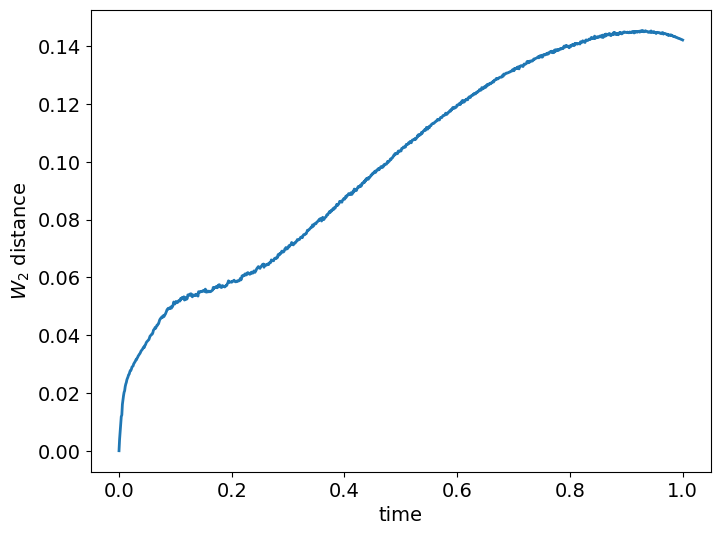

In [87]:
## Generate Wasserstein (W2) plot

import ot
w2_dist = []
# Uniform weights if distributions are unweighted
a = np.ones(N) / N # Uniform weights for X
b = np.ones(N) / N # Uniform weights for Y

dist_0 =  ot.dist(x_0, y) 
w2_dist_norm = np.sqrt(ot.emd2(a, b, dist_0))

for i in range(T):
    if i% 10 ==0:
        print(f'{i}/{T}')
    # Compute the cost matrix (usually the Euclidean distance matrix)
    dist =  ot.dist(X_p[i,], X_f[i,]) 

    # Compute the Wasserstein distance (emd2 returns the squared distance)
    w2_dist.append(np.sqrt(ot.emd2(a, b, dist))/w2_dist_norm)

plt.figure(figsize=(8,6 ))
plt.plot(t_N[:,0,0],w2_dist,lw=2)
plt.xlabel(r'time')
plt.ylabel(r'$W_2$ distance')
plt.show()